In [1]:
import polars as pl
import pandas as pd
import lightgbm as lgb
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split

In [2]:
base_dir = '../data/processed/grouped/new_aggs/'
files = glob.glob(base_dir + '*')

In [3]:
df_0 = pl.read_parquet('../data/raw/parquet_files/train/train_base.parquet')
df_1 = pl.read_parquet('../data/raw/parquet_files/train/train_base.parquet')
for file in files:
    path = Path(file)
    temp_df = pl.read_parquet(file)
    if path.stem[-1] == '0':    # num_group1 == 0
        df_0 = df_0.join(temp_df, how='left', on='case_id')
    elif path.stem[-1] == 't':  # num_group1 != 0
        df_1 = df_1.join(temp_df, how='left', on='case_id')
    else:                       # static data
        df_0 = df_0.join(temp_df, how='left', on='case_id')
        df_1 = df_1.join(temp_df, how='left', on='case_id')

df_0 = df_0.drop(['date_decision', 'MONTH'])
df_1 = df_1.drop(['date_decision', 'MONTH'])

for col in df_0.columns:
    if df_0[col].dtype == pl.Date:
        df_0 = df_0.with_columns(pl.col(col).cast(pl.Int64))

for col in df_1.columns:
    if df_1[col].dtype == pl.Date:
        df_1 = df_1.with_columns(pl.col(col).cast(pl.Int64))

In [4]:
case_ids_0 = df_0['case_id'].unique().shuffle(seed=28).to_list()    # Must be list
case_ids_1 = df_1['case_id'].unique().shuffle(seed=28).to_list()

In [5]:
def case_ids_to_df(df: pl.DataFrame, case_ids: list) -> tuple[pl.DataFrame]:
    pred_cols = df.drop(['case_id', 'target']).columns
    
    return (
        df.filter(pl.col('case_id').is_in(case_ids))[pred_cols],
        df.filter(pl.col('case_id').is_in(case_ids))['target'].to_pandas()  # Must be numpy 1D Array or pandas Series
    )

In [6]:
case_ids_0_train, case_ids_0_val = train_test_split(case_ids_0, train_size=0.8, random_state=28)
X_train_0, y_train_0 = case_ids_to_df(df_0, case_ids_0_train)
X_val_0, y_val_0 = case_ids_to_df(df_0, case_ids_0_val)

case_ids_1_train, case_ids_1_val = train_test_split(case_ids_1, train_size=0.8, random_state=28)
X_train_1, y_train_1 = case_ids_to_df(df_1, case_ids_1_train)
X_val_1, y_val_1 = case_ids_to_df(df_1, case_ids_1_val)

assert X_train_0.shape[0] + X_val_0.shape[0] == df_0.shape[0]
assert X_train_1.shape[0] + X_val_1.shape[0] == df_1.shape[0]

## Num Group 1 Equals 0

In [7]:
lgb_train_0 = lgb.Dataset(X_train_0, label=y_train_0)
lgb_valid_0 = lgb.Dataset(X_val_0, label=y_val_0, reference=lgb_train_0)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm_0 = lgb.train(
    params,
    lgb_train_0,
    valid_sets=lgb_valid_0,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(50)]
)

/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.789021
[100]	valid_0's auc: 0.80908
[150]	valid_0's auc: 0.816626
[200]	valid_0's auc: 0.820752
[250]	valid_0's auc: 0.823324
[300]	valid_0's auc: 0.825556
[350]	valid_0's auc: 0.827074
[400]	valid_0's auc: 0.828324
[450]	valid_0's auc: 0.829448
[500]	valid_0's auc: 0.830299
[550]	valid_0's auc: 0.83101
[600]	valid_0's auc: 0.831701
[650]	valid_0's auc: 0.832205
[700]	valid_0's auc: 0.83279
[750]	valid_0's auc: 0.83327
[800]	valid_0's auc: 0.833712
[850]	valid_0's auc: 0.834139
[900]	valid_0's auc: 0.834567
[950]	valid_0's auc: 0.834903
[1000]	valid_0's auc: 0.835107
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.835107


In [8]:
pred_cols_0 = df_0.drop(['case_id', 'target']).columns
feat_imps_0 = gbm_0.feature_importance()

assert feat_imps_0.shape[0] == len(pred_cols_0)

feat_df_0 = pd.DataFrame({'feature': pred_cols_0, 'importance': feat_imps_0})
feat_df_0 = feat_df_0.sort_values(by='importance', ascending=False)

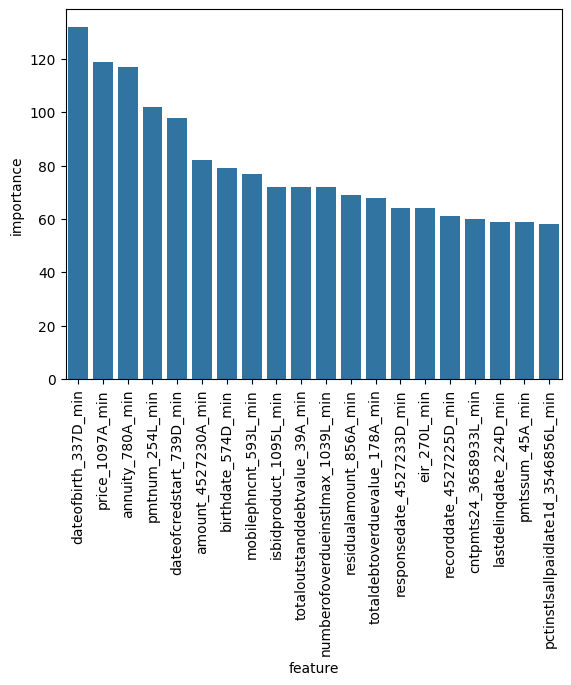

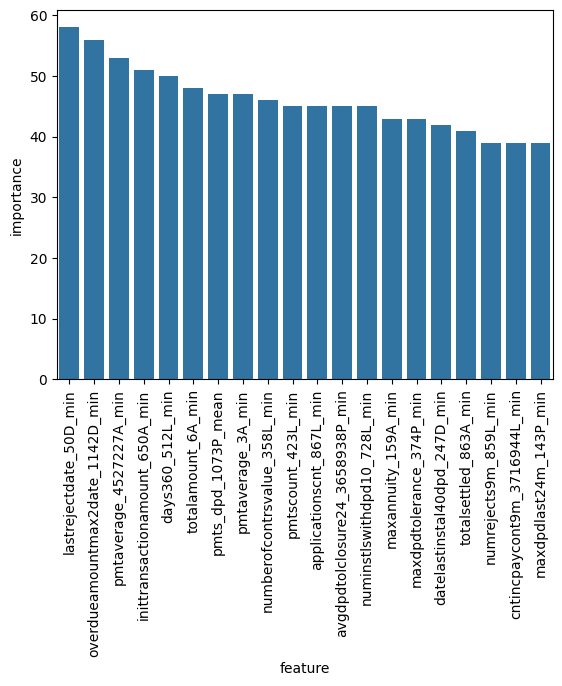

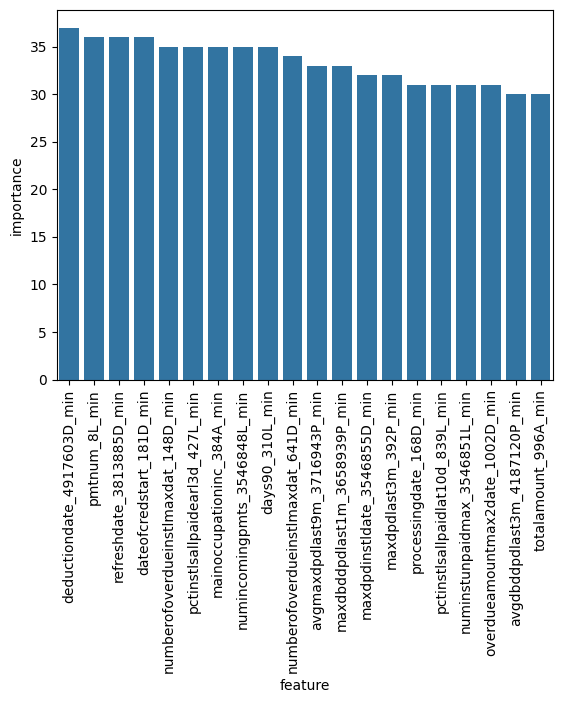

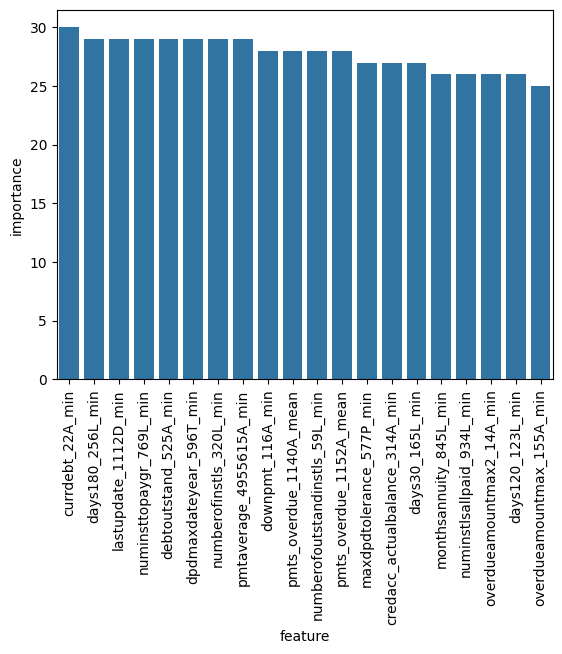

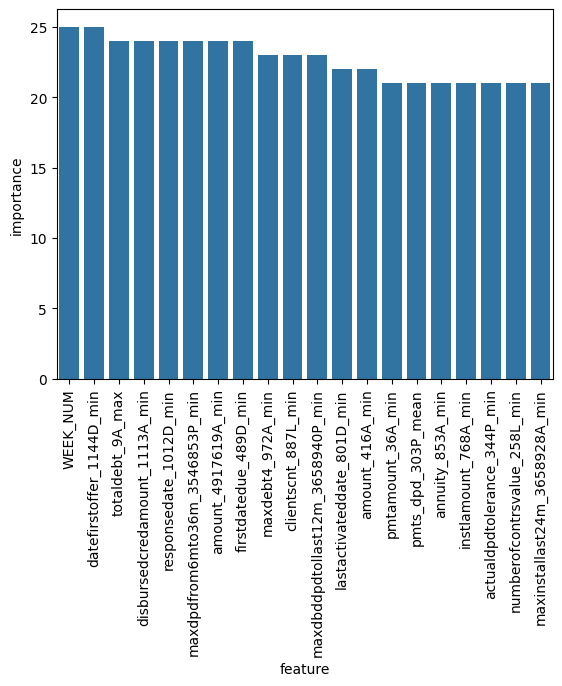

In [11]:
for i in range(100 // 20):
    start = i*20
    end = start + 20
    sns.barplot(feat_df_0.iloc[start:end, :], x='feature', y='importance')
    plt.xticks(rotation=90)

    plt.show()

## Num Group 1 Equals Rest

In [12]:
lgb_train_1 = lgb.Dataset(X_train_1, label=y_train_1)
lgb_valid_1 = lgb.Dataset(X_val_1, label=y_val_1, reference=lgb_train_1)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm_1 = lgb.train(
    params,
    lgb_train_1,
    valid_sets=lgb_valid_1,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(50)]
)

/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.781712
[100]	valid_0's auc: 0.80148
[150]	valid_0's auc: 0.809533
[200]	valid_0's auc: 0.813828
[250]	valid_0's auc: 0.81723
[300]	valid_0's auc: 0.819387
[350]	valid_0's auc: 0.821053
[400]	valid_0's auc: 0.822249
[450]	valid_0's auc: 0.823398
[500]	valid_0's auc: 0.824323
[550]	valid_0's auc: 0.825122
[600]	valid_0's auc: 0.825807
[650]	valid_0's auc: 0.826427
[700]	valid_0's auc: 0.827154
[750]	valid_0's auc: 0.827588
[800]	valid_0's auc: 0.828126
[850]	valid_0's auc: 0.828501
[900]	valid_0's auc: 0.828786
[950]	valid_0's auc: 0.82916
[1000]	valid_0's auc: 0.82942
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.82942


In [13]:
pred_cols_1 = df_1.drop(['case_id', 'target']).columns
feat_imps_1 = gbm_1.feature_importance()

assert feat_imps_1.shape[0] == len(pred_cols_1)

feat_df_1 = pd.DataFrame({'feature': pred_cols_1, 'importance': feat_imps_1})
feat_df_1 = feat_df_1.sort_values(by='importance', ascending=False)

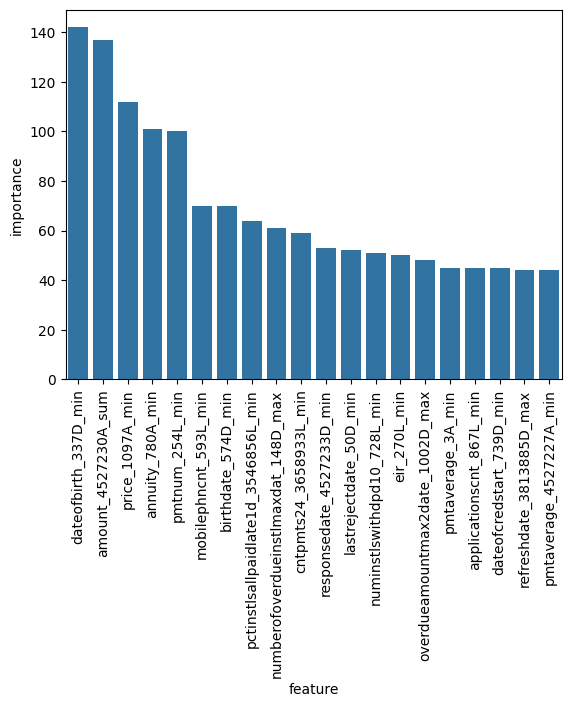

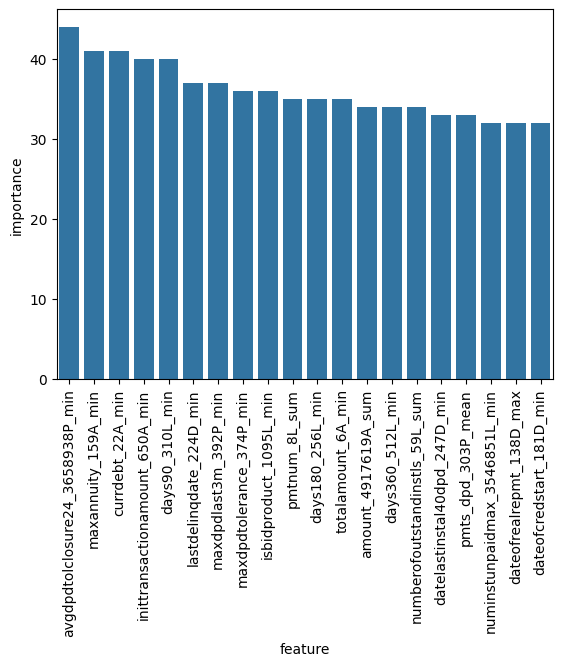

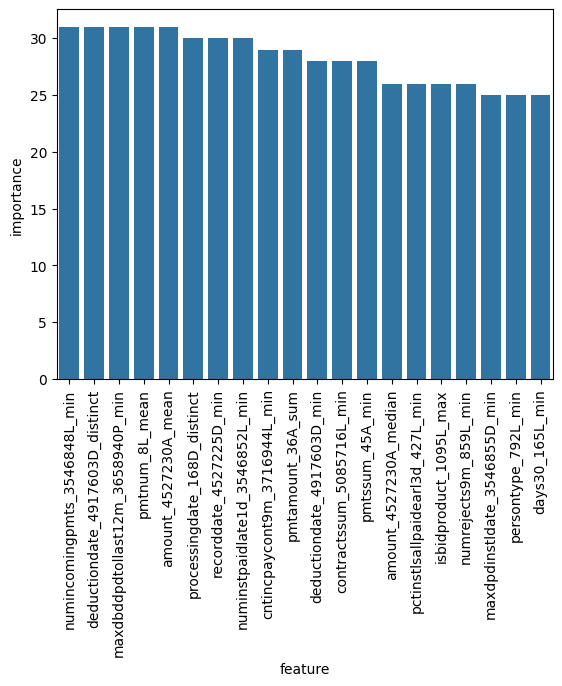

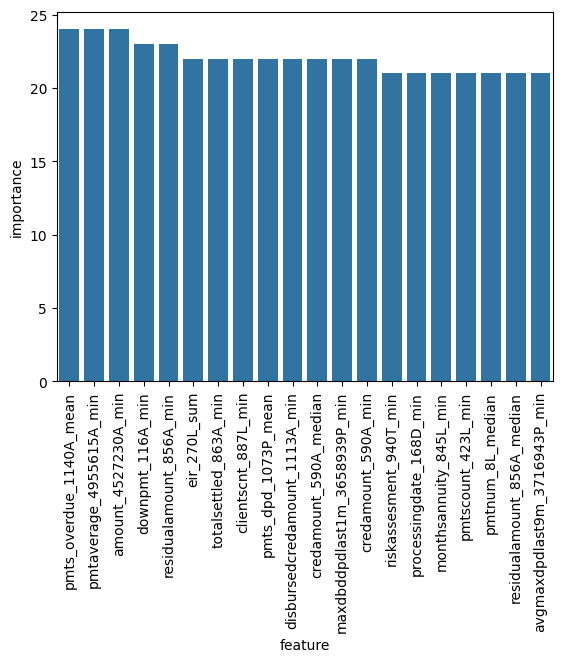

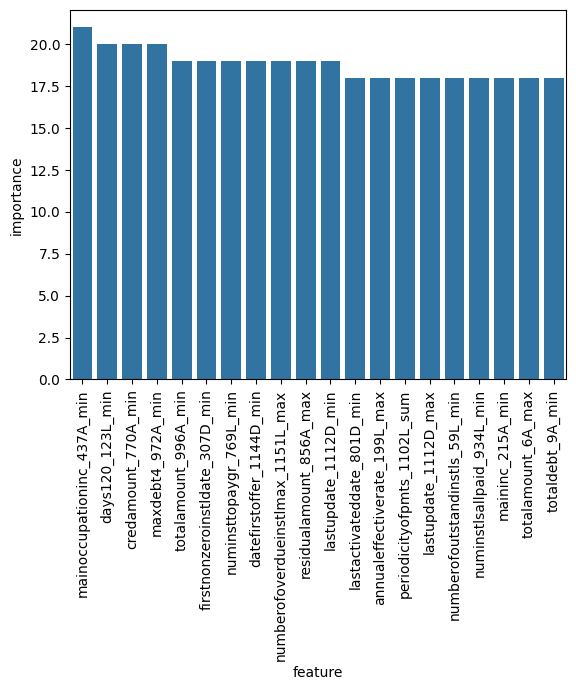

In [14]:
for i in range(100 // 20):
    start = i*20
    end = start + 20
    sns.barplot(feat_df_1.iloc[start:end, :], x='feature', y='importance')
    plt.xticks(rotation=90)

    plt.show()